# ASTR4004 Assignment 3 Question 3

## 3.1 Background

The radial metallicity relation is a function that descirbes the change of metallicity - here the gas phase metallicty $\mathrm{A(O)} = \log_{10}(N_\mathrm{O}/N_\mathrm{H}) + 12$ - along the galacocentric radius $R_\mathrm{Gal}$. Understanding the radial metallicty gradient in galaxies provides critical insights into their formation and evolutionary processes, such as inside-out formation, gas accretion, outflows, and radial migration. A lot of work has been done through obsevational studies (e.g. Ho et al., 2017, ApJ, 846, 39) and a few simualtions and a few simulations (e.g. Grand et al., 2016, MNRAS, 460, 94), but more works needs to be done to understand the radial metallicity gradient!

Your colleage has just finished an exciting cosmological simulation that traces the gas phase metallicity for a Milky Way analogue, that is, a sprial galaxy. They have limited the simulation data to the positions $(\mathrm{x, y, z})$ of the innermost gas particles ($R_\mathrm{Gal} < 25\,\mathrm{kpc}$) and their gas phase metallicity $\mathrm{A(O)}$ and uploaded them as a FITS file for you here: https://github.com/svenbuder/astr4004_2024_week7/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits.

## 3.2 Task

Downlaod the file from the link above into $\verb|data/|$. Load the file with $\verb|python|$ and then perform the following tasks to create figures that are saved in $\verb|figures/|$: 

In [21]:
## start by importing any relevant pkgs

import astropy.constants as c 
import astropy.units as u 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import glob
from astropy.io import fits
import smplotlib
from sklearn.metrics import mean_squared_error
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm


## assign relevant directories

# question 2 directories
data_dir_q2 = 'question-2/data'
fig_dir_q2 = 'question-2/figures'

# question 3 directories
data_dir_q3 = 'question-3/data'
fig_dir_q3 = 'question-3/figures'

### 3.2 Intro - Data Handling

In [2]:
## read in the FITS data file
nihao_sim_fits = fits.open(glob.glob(os.path.join(data_dir_q3, f'*.fits'))[0])
nihao_sim_data = nihao_sim_fits[1].data # each row n has 4 elements in the format (x, y, z, A(O))

## store data in relevant lists
xlist = []
ylist = []
zlist = []
gas_met_list = []

for row in range(len(nihao_sim_data)):
    xlist.append(nihao_sim_data[row][0])
    ylist.append(nihao_sim_data[row][1])
    zlist.append(nihao_sim_data[row][2])
    gas_met_list.append(nihao_sim_data[row][3])

# convert these lists to arrays for easy computation
xarr = np.array(xlist)
yarr = np.array(ylist)
zarr = np.array(zlist)
gas_met_arr= np.array(gas_met_list)

### Question 3.2.1 

Plot a 2-panel figure:
 - (a) Logarithmic density plot of $R_\mathrm{Gal}$ vs. $\mathrm{A(O)}$, with a linear fit and legend.
 - (b) Residuals of the fit, $R_\mathrm{Gal}$ vs. $\mathrm{\Delta A(O)}$. 


### Question 3.2.2 

Use a $\verb|python|$ fitting tool to fit a linear function to the data, reporting the intercept and slope with uncertainties. Include an hyperparameters used.

Linear fit parameters: slope = -0.03325 ± 0.00002, intercept = 9.12232 ± 0.00028


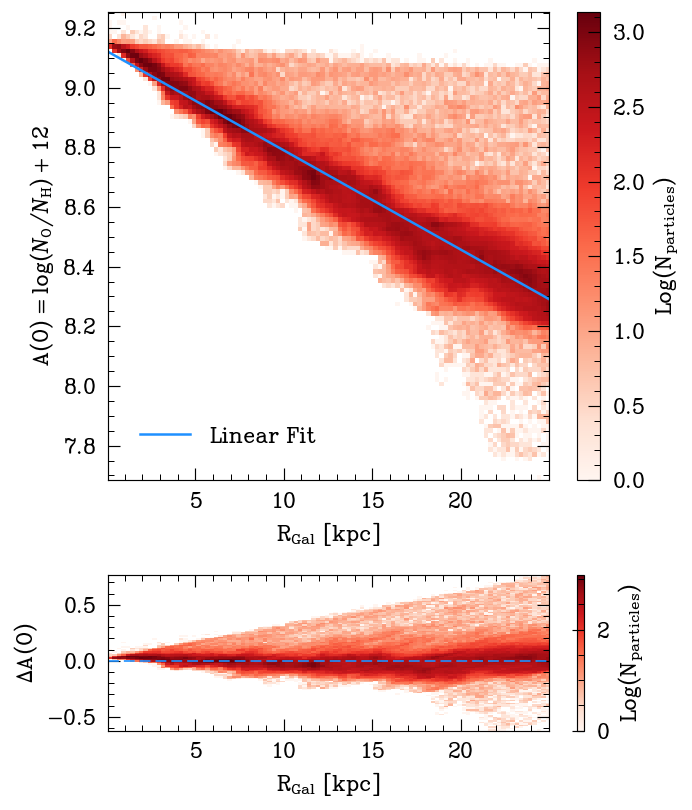

In [204]:
" ---------------- Q3.2.1 PLOTTING THE DATA ---------------- "

# compute Rgal
R_gal = np.sqrt(xarr**2 + yarr**2 + zarr**2)

## make the plot for 3.2.1
fig = plt.figure(figsize=(6, 7))
gs = GridSpec(2, 1, height_ratios=[3, 1])  

##  create plot (a)
ax1 = fig.add_subplot(gs[0])

# histogram w/ logarithmic densities
h1, xedges, yedges = np.histogram2d(R_gal, gas_met_arr, bins=100)
h1_log = np.log10(h1) 

# plot the logarithmic densities using an imshow
im1 = ax1.imshow(h1_log.T, origin='lower', aspect='auto', 
                 extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Reds')

# add a colour bar
cbar1 = plt.colorbar(im1, ax=ax1, label='Log($\mathrm{N_{particles}})$')

## axes config for ax1
ax1.set_xlabel('$\mathrm{R_{Gal}}$ [kpc]')
ax1.set_ylabel('$\mathrm{A(O)} = \log(N_\mathrm{O}/N_\mathrm{H}) + 12$')


" ---------------- Q3.2.2 FITTING A LINE TO THE DATA ---------------- "

### 3.2.2 fit a line to the data
mask = np.isfinite(R_gal) & np.isfinite(gas_met_arr)  # mask any nan or inf
coeffs, cov = np.polyfit(R_gal[mask], gas_met_arr[mask], 1, cov=True)  # deg 1 for linear

# get the intercept and slope fo the fit
slope = coeffs[0]
intercept = coeffs[1]

# get the uncertainties on the fit (given by the diagonals of the cov array)
slope_err = np.sqrt(cov[0,0])
intercept_err = np.sqrt(cov[1,1])

# print the values of the fit
print(f'Linear fit parameters: slope = {slope:.5f} ± {slope_err:.5f}, intercept = {intercept:.5f} ± {intercept_err:.5f}')

# get the line and plot it
fit_line = np.polyval(coeffs, np.sort(R_gal[mask]))
ax1.plot(np.sort(R_gal[mask]), fit_line, color='dodgerblue', linestyle='solid', linewidth=1.5, label='Linear Fit')

ax1.legend(loc = 'lower left')

# compute resid
residuals = gas_met_arr[mask] - np.polyval(coeffs, R_gal[mask])

# create smaller residual plot below main plot
ax2 = fig.add_subplot(gs[1])

# histogram with log densities
h2, xedges2, yedges2 = np.histogram2d(R_gal[mask], residuals, bins=100)
h2_log = np.log10(h2)  

# plot resid using imshow
im2 = ax2.imshow(h2_log.T, origin='lower', aspect='auto', 
                 extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]], cmap='Reds')

# plot a horizontal line at 0 
ax2.axhline(0, color = 'dodgerblue', linewidth=1,  linestyle='dashed')

# add color bar
cbar2 = plt.colorbar(im2, ax=ax2, label='Log($\mathrm{N_{particles}})$')

## axes config for ax2
ax2.set_xlabel('$\mathrm{R_{Gal}}$ [kpc]')
ax2.set_ylabel('$\mathrm{\Delta A(O)}$')


plt.tight_layout()

# save the figure to the relevant directory
plt.savefig(os.path.join(fig_dir_q3, 'q3.2.1_log_density_plot.pdf'))

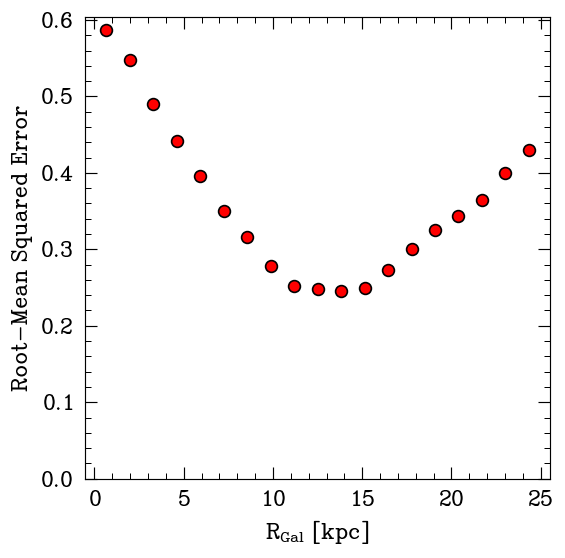

In [203]:
" ----------- Q3.2.3 ------------- "

## we can approach the problem by considering the root mean square in bins of Rgal

# define bins for rmse calc
# bins_rmse = [0, 5, 10 ,15, 20, 25]
bins_rmse = np.linspace(0, np.max(R_gal), 20)

# get the bin centers for plotting
bin_centers = []

for i in range(len(bins_rmse)-1):
    bin_center = ((bins_rmse[i] + bins_rmse[i+1])/2)
    bin_centers.append(bin_center)

rmse_list = [] 

# iterate over bins and calculate root mean square error (rmse) in each bin
for i in range(len(bins_rmse)-1):
    bin_mask = ((R_gal[mask] >= bins_rmse[i]) & (R_gal[mask] < bins_rmse[i+1])) # create a mask such that you only consider the binned region
    if np.any(bin_mask): 
        bin_rmse = np.sqrt(mean_squared_error(gas_met_arr[mask][bin_mask], fit_line[bin_mask]))
        rmse_list.append(bin_rmse)


## plot the RMSE as a fucntion of bins
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(bin_centers, rmse_list, s=50, color='red', edgecolors='black')

# axes config
ax.set_xlabel('$\mathrm{R_{Gal}}$ [kpc]')
ax.set_ylabel('Root-Mean Squared Error')

ax.set_ylim(0)

plt.savefig(os.path.join(fig_dir_q3, 'q323_rmse.pdf'))

Evidently, the linear fit is most poor at the inner part of the galaxy within 10 kpc and in the outer galaxy above 15 kpc while the best fit region is between 10-15 kpc. Overall though, the fit is generally sound.

### Question 3.2.4

Plot a 3-panel figure for the $x \mathrm{\,vs.\,} y$ plane using the same bins and sensible colormaps:
- (a) 2D-histogram of the median simulated $\mathrm{A(O)}$ 
- (b) 2D-histogram of the median fitted $\mathrm{A(O)}$
- (c) 2D-histogram of the median residuals $\mathrm{\Delta A(O)}$

In [206]:
" ----------- Q3.2.4 ------------- "

# get x and y bin edges
bins_x = np.linspace(np.min(xarr), np.max(xarr), 75)
bins_y = np.linspace(np.min(yarr), np.max(yarr), 75)

# get R_gal bin edges
bins_Rgal = np.linspace(np.min(R_gal), np.max(R_gal), len(fit_line))

# create a function to calculate the median in 2d bins
def median2d(x, y, values, bins_x, bins_y):
    median = np.zeros((len(bins_x) - 1, len(bins_y) - 1))
    for i in range(len(bins_x) - 1):
        for j in range(len(bins_y) - 1):
            bin_mask = (x >= bins_x[i]) & (x < bins_x[i + 1]) & (y >= bins_y[j]) & (y < bins_y[j + 1])
            if np.any(bin_mask):
                median[i, j] = np.median(values[bin_mask])
            else:
                median[i, j] = np.nan  
    return median

## (a) calculate the median sim A(O)
median_sim_AO = median2d(xarr, yarr, gas_met_arr, bins_x, bins_y)

## (b) project the fitted A(O) onto the x-y plane
projected_fit_AO = np.zeros_like(R_gal)
for i in range(len(R_gal)):
    Rgal_idx = np.digitize(R_gal[i], bins_Rgal) - 1 # find the bin index in R_gal corresponding to this data point and convert to 0-based idx
    Rgal_idx = np.clip(Rgal_idx, 0, len(fit_line) - 1)  # make sure the index is in the correct range
    projected_fit_AO[i] = fit_line[Rgal_idx] # assign the fitted A(O) value for this radius

# calculate the median of the projected fitted A(O) in 2D bins
median_fit_AO = median2d(xarr, yarr, projected_fit_AO, bins_x, bins_y)

## (c) calculate the median residuals
median_residuals = median_sim_AO - median_fit_AO


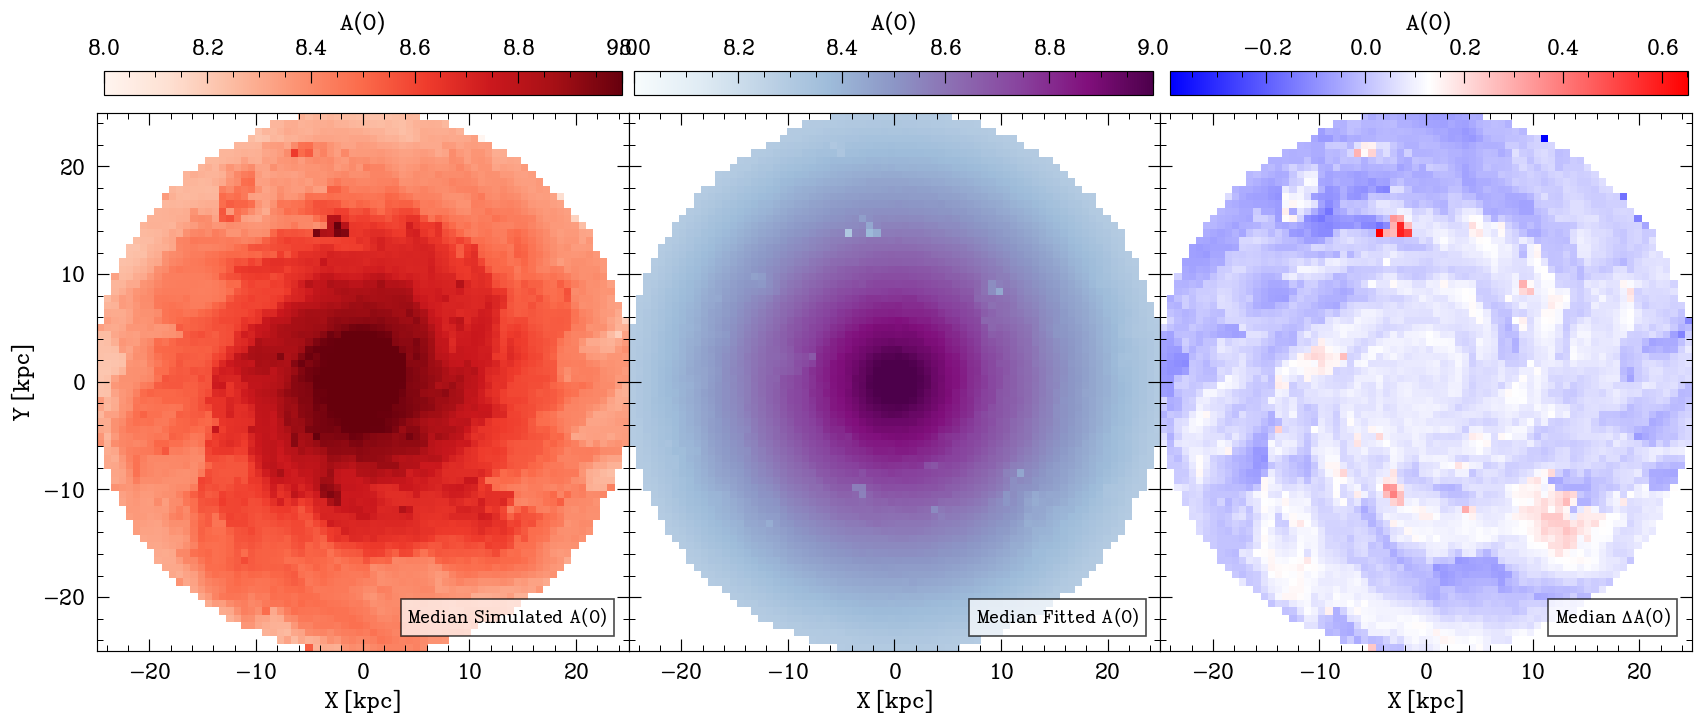

In [207]:
# create a 3 panel
fig, axs = plt.subplots(1,3, figsize=(14, 5), sharey=True)

plt.subplots_adjust(wspace=-1)

## (a) median simualted A(O)
im1 = axs[0].imshow(median_sim_AO, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], cmap='Reds', vmin=8, vmax=9)

# add text to describe what the plot is showing
axs[0].text(0.96, 0.04, 'Median Simulated $\mathrm{A(O)}$', transform=axs[0].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[0].set_xlabel('X [kpc]')
axs[0].set_ylabel('Y [kpc]')

# add a colour bar above the plot
cax1 = fig.add_axes([0.0545, 1.03, 0.3085, 0.04]) 
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('A(O)', labelpad=-50)  
cbar1.ax.xaxis.set_label_position('bottom')  

cbar1.ax.xaxis.set_ticks_position('top') 
cbar1.ax.xaxis.set_tick_params(labeltop=True)  

## (b) median simualted A(O)
im2 = axs[1].imshow(median_fit_AO, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], cmap='BuPu',  vmin=8, vmax=9)

# add text to describe what the plot is showing
axs[1].text(0.96, 0.04, 'Median Fitted $\mathrm{A(O)}$', transform=axs[1].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[1].set_xlabel('X [kpc]')


# add a colour bar above the plot
cax2 = fig.add_axes([0.062 +  0.3085, 1.03, 0.3085, 0.04])  
cbar2 = fig.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('A(O)', labelpad=-50)  
cbar2.ax.xaxis.set_label_position('bottom')  

cbar2.ax.xaxis.set_ticks_position('top')  
cbar2.ax.xaxis.set_tick_params(labeltop=True)  

# (c) 2D-histogram of the median residuals ∆A(O)
im3 = axs[2].imshow(median_residuals, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], cmap='bwr')

axs[2].text(0.96, 0.04, 'Median $\Delta\mathrm{A(O)}$', transform=axs[2].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[2].set_xlabel('X [kpc]')

# add a colour bar above the plot
cax3 = fig.add_axes([0.062 +  0.627, 1.03, 0.3085, 0.04])  
cbar3 = fig.colorbar(im3, cax=cax3, orientation='horizontal')
cbar3.set_label('A(O)', labelpad=-50)  
cbar3.ax.xaxis.set_label_position('bottom')  

cbar3.ax.xaxis.set_ticks_position('top')  
cbar3.ax.xaxis.set_tick_params(labeltop=True)  


# adjust layout to avoid overlap
plt.tight_layout(pad=0)

plt.savefig(os.path.join(fig_dir_q3,f'q324_3_panel_2d_hist.pdf'))

### Question 3.2.5 

Describe your choice of 2d bins. Discuss what detaisl would be missed with few bins or problems encountered with more bins.

The choice of 2D bins is motivated by the aim to capture structural features in the simulated galaxy while minimising computational cost. If too few bins were used, the structure in the galaxy, namely the spiral arms, would not be captured and the galaxy would appear relatively featureless on such a scale. However, the bin number cannot be increased significantly as this would be significantly computatioanlly expensive.

### Question 3.2.6

Analyze the residuals in more detail and propose an explanation for any patterns you observe.

From observing the residual panel it is clear that the 1D linear model of the gas-phase metallicity is not capable of capturing the structure in the galaxy on the level of the spiral arms. 